<a href="https://colab.research.google.com/github/rivaldo1403/Model-yolo-untuk-dataset-kupu-kupu/blob/main/DEEPL_YOLOv8_UAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os
import shutil
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
from PIL import Image
import yaml

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Set the home directory to Colab working directory
HOME = os.getcwd()
print(HOME)

/content


#Augmentasi data

In [ ]:
# # Define the dataset path in your Google Drive
# dataset_path = '/content/drive/My Drive/dataset/dataset_cnn'  # Change to the correct folder
# output_path = '/content/drive/My Drive/augmented_dataset'

In [ ]:
# # Buat folder output jika belum ada
# os.makedirs(output_path, exist_ok=True)

# # Fungsi untuk melakukan augmentasi gambar
# def augment_images(folder_path, output_folder, target_count=150):
#     # Dapatkan semua file gambar dalam folder
#     images = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

#     # Salin gambar asli ke folder output
#     for image in images:
#         shutil.copy(os.path.join(folder_path, image), os.path.join(output_folder, image))

#     # Hitung jumlah gambar yang ada setelah penyalinan
#     current_count = len(images)
#     print(f"Current count in {output_folder}: {current_count}")

#     # Jika jumlah gambar kurang dari target, lakukan augmentasi
#     if current_count < target_count:
#         additional_needed = target_count - current_count
#         print(f"Augmenting {additional_needed} images in {folder_path}")

#         # Lakukan rotasi untuk augmentasi
#         for i in range(additional_needed):
#             for image in images:
#                 img_path = os.path.join(folder_path, image)
#                 img = Image.open(img_path)

#                 # Rotasi gambar dengan sudut yang berbeda
#                 rotated_img = img.rotate(i * (360 / additional_needed))  # Rotasi dengan sudut yang berbeda
#                 rotated_img_name = f'aug_{i}_{image}'

#                 # Cek nama file untuk karakter yang tidak valid
#                 rotated_img_name = rotated_img_name.replace(":", "_").replace("/", "_")

#                 # Simpan gambar yang telah dirotasi
#                 try:
#                     rotated_img.save(os.path.join(output_folder, rotated_img_name))
#                     print(f"Saved augmented image: {rotated_img_name}")
#                 except Exception as e:
#                     print(f"Error saving image {rotated_img_name}: {e}")

#                 # Cek jika sudah mencapai target
#                 if len(os.listdir(output_folder)) >= target_count:
#                     print(f"Reached target count of {target_count} in {output_folder}")
#                     return

# # Dapatkan semua subfolder dalam dataset
# subfolders = [f.path for f in os.scandir(dataset_path) if f.is_dir()]

# # Proses setiap subfolder
# for subfolder in subfolders:
#     folder_name = os.path.basename(subfolder)
#     output_folder = os.path.join(output_path, folder_name)
#     os.makedirs(output_folder, exist_ok=True)

#     # Lakukan augmentasi gambar
#     augment_images(subfolder, output_folder)

# print("Augmentasi selesai!")

In [ ]:
# Define the dataset path in your Google Drive
dataset_path = '/content/drive/My Drive/augmented_dataset'  # Ganti dengan folder augmentasi
output_path = '/content'  # Simpan di Google Colab

In [ ]:
# Create the necessary folder structure for the dataset
def create_folder_structure(base_path):
    folders = [
        'data/train/images', 'data/train/labels',
        'data/val/images', 'data/val/labels',
        'data/test/images', 'data/test/labels'
    ]
    for folder in folders:
        os.makedirs(os.path.join(base_path, folder), exist_ok=True)

create_folder_structure(output_path)

In [ ]:
# Process the dataset and organize files
def process_dataset(dataset_path, output_path):
    # Kelas kupu-kupu
    classes = ['kupu_batik_cap', 'kupu_harimau_kuning_hijau', 'kupu_hijau_biru',
               'kupu_jarak', 'kupu_jojo', 'kupu_pantat_merah',
               'kupu_raja_helena', 'kupu_raja_limau']

    # Mengumpulkan file gambar dari semua folder
    image_files = []
    for class_name in classes:
        class_folder = os.path.join(dataset_path, class_name)

        # Cek jika folder kelas ada
        if os.path.exists(class_folder):
            files = [(f, class_name) for f in os.listdir(class_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            if files:  # Hanya tambahkan jika ada file
                image_files.extend(files)
            else:
                print(f"No images found in {class_folder}.")
        else:
            print(f"Folder {class_folder} does not exist. Skipping...")

    # Cek jika tidak ada gambar yang ditemukan
    if not image_files:
        print("No images found in any class folders. Exiting...")
        return

    # Split the dataset into train, val, and test sets
    train_val, test = train_test_split(image_files, test_size=0.1, random_state=42)  # 10% untuk test
    train, val = train_test_split(train_val, test_size=0.2222, random_state=42)  # 20% dari 90% untuk val

    # Create output directories once
    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(output_path, f'data/{split}/images'), exist_ok=True)
        os.makedirs(os.path.join(output_path, f'data/{split}/labels'), exist_ok=True)

    # Process and move files
    for split, files in [('train', train), ('val', val), ('test', test)]:
        for file_name, class_name in files:
            # Define source and destination paths for the image
            src_img = os.path.join(dataset_path, class_name, file_name)
            dst_img = os.path.join(output_path, f'data/{split}/images', file_name)

            shutil.copy(src_img, dst_img)

            # Generate YOLO label for the class
            class_id = classes.index(class_name)
            label_file = os.path.splitext(file_name)[0] + '.txt'
            dst_label = os.path.join(output_path, f'data/{split}/labels', label_file)

            # Write YOLO label (full image represents the class, no bounding box)
            with open(dst_label, 'w') as label_out:
                # The format is "class_id center_x center_y width height" (centered, full image)
                label_out.write(f"{class_id} 0.5 0.5 1.0 1.0\n")

    # Create data.yaml for YOLO
    yaml_content = {
        'train': f'{output_path}/data/train/images',
        'val': f'{output_path}/data/val/images',
        'test': f'{output_path}/data/test/images',
        'nc': len(classes),  # Jumlah kelas
        'names': classes  # Nama kelas sesuai dataset Anda
    }

    # Save the data.yaml file with corrected structure
    yaml_file_path = os.path.join(output_path, 'data.yaml')  # Simpan di output_path
    with open(yaml_file_path, 'w') as yaml_file:
        yaml.dump(yaml_content, yaml_file, default_flow_style=False)

    print(f"Data YAML saved at: {yaml_file_path}")

# Example usage
process_dataset(dataset_path, output_path)
print("Dataset preparation completed.")

Data YAML saved at: /content/data.yaml
Dataset preparation completed.


In [ ]:
!pip install albumentations==1.4

##YOLOv8

In [ ]:
!pip install -U ultralytics


In [ ]:
from ultralytics import YOLO

# Load the YOLOv8 model
model = YOLO("yolov8n.pt")  # Use 'yolov8n.pt' for YOLOv8 nano model, or replace with 'yolov8s.pt' etc.

# Train the model on your custom dataset
model.train(
    data="/content/data.yaml",  # Path to the data.yaml file created in your previous setup
    epochs=15,                       # Set the number of epochs
    batch=16,                        # Set the batch size
    imgsz=640,                       # Image size for training
    project="/content/runs",         # Output project folder
    name="detect_yolov8",            # Run name
    device=0                         # Use GPU (if available), set to 'cpu' for CPU
)


Ultralytics 8.3.51 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/data.yaml, epochs=15, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=/content/runs, name=detect_yolov82, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, sho

train: Scanning /content/data/train/labels... 1029 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1029/1029 [00:17<00:00, 58.37it/s] 

train: WARNING ⚠️ /content/data/train/images/Kupu Batik Cap-18.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /content/data/train/images/Kupu Batik Cap-19.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /content/data/train/images/Kupu Batik Cap-20.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /content/data/train/images/Kupu Batik Cap-21.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /content/data/train/images/Kupu Batik Cap-25.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /content/data/train/images/Kupu Batik Cap-30.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /content/data/train/images/Kupu Batik Cap-32.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /content/data/train/images/Kupu Batik Cap-34.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /content/data/train/images/Kupu Batik Cap-35.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /content/data/train/images/Kupu Batik Cap-37.jpg: corrupt JPEG restored and saved


train: New cache created: /content/data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/data/val/labels... 386 images, 0 backgrounds, 0 corrupt: 100%|██████████| 386/386 [00:11<00:00, 33.44it/s]

val: WARNING ⚠️ /content/data/val/images/Kupu Batik Cap-36.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/data/val/images/Kupu Batik Cap-38.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/data/val/images/Kupu Batik Cap-40.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/data/val/images/Kupu Batik Cap-73.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/data/val/images/Kupu Hijau Biru-33.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/data/val/images/Kupu Pantat Merah-28.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/data/val/images/Kupu Pantat Merah-30.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/data/val/images/Kupu Pantat Merah-31.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/data/val/images/Kupu Pantat Merah-33.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/data/val/images/Kupu Pantat Merah-34.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content

val: New cache created: /content/data/val/labels.cache
Plotting labels to /content/runs/detect_yolov82/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000833, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/runs/detect_yolov82
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15      2.36G     0.3002      2.765      1.039         11        640: 100%|██████████| 65/65 [02:36<00:00,  2.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:49<00:00,  3.79s/it]


                   all        386        386      0.855      0.597      0.848      0.846

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15      2.34G     0.1706      1.152     0.9138         16        640: 100%|██████████| 65/65 [02:35<00:00,  2.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:54<00:00,  4.20s/it]


                   all        386        386      0.906      0.952      0.988      0.888

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15      2.42G     0.1548     0.8879     0.9059         16        640: 100%|██████████| 65/65 [03:10<00:00,  2.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [01:07<00:00,  5.16s/it]


                   all        386        386      0.856      0.896      0.974       0.91

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15      2.41G     0.1485     0.7796     0.9052         18        640: 100%|██████████| 65/65 [02:40<00:00,  2.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:50<00:00,  3.90s/it]


                   all        386        386      0.956      0.985      0.989      0.956

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15      2.36G     0.1359     0.7069     0.8972         13        640: 100%|██████████| 65/65 [02:42<00:00,  2.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:42<00:00,  3.27s/it]


                   all        386        386      0.987      0.992      0.994      0.993
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/15      2.42G     0.1448      1.086     0.9074          5        640: 100%|██████████| 65/65 [02:39<00:00,  2.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:40<00:00,  3.09s/it]


                   all        386        386      0.995      0.993      0.995      0.995

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/15      2.42G     0.1298     0.7968     0.8879          5        640: 100%|██████████| 65/65 [02:27<00:00,  2.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:41<00:00,  3.21s/it]


                   all        386        386      0.986      0.991      0.995      0.994

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/15      2.41G      0.119     0.6936     0.8765          5        640: 100%|██████████| 65/65 [02:45<00:00,  2.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:50<00:00,  3.92s/it]


                   all        386        386      0.991      0.984      0.995      0.984

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/15      2.33G    0.09285     0.5647      0.867          5        640: 100%|██████████| 65/65 [02:48<00:00,  2.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:44<00:00,  3.46s/it]


                   all        386        386       0.99      0.986      0.993      0.992

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/15      2.42G    0.08744     0.5244     0.8723          5        640: 100%|██████████| 65/65 [02:31<00:00,  2.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:44<00:00,  3.39s/it]


                   all        386        386      0.999          1      0.995      0.995

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/15      2.42G    0.07923     0.4594     0.8536          5        640: 100%|██████████| 65/65 [02:28<00:00,  2.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:40<00:00,  3.15s/it]

                   all        386        386      0.997          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/15      2.41G    0.06928     0.4213     0.8464          5        640: 100%|██████████| 65/65 [02:24<00:00,  2.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:41<00:00,  3.19s/it]


                   all        386        386      0.999          1      0.995      0.995

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/15      2.33G     0.0643      0.386     0.8441          5        640: 100%|██████████| 65/65 [04:09<00:00,  3.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:51<00:00,  3.96s/it]

                   all        386        386      0.998          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/15      2.42G    0.05529      0.356     0.8519          5        640: 100%|██████████| 65/65 [03:11<00:00,  2.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:42<00:00,  3.28s/it]

                   all        386        386      0.998          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/15      2.42G    0.04816     0.3412     0.8496          5        640: 100%|██████████| 65/65 [02:45<00:00,  2.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:43<00:00,  3.32s/it]


                   all        386        386      0.999          1      0.995      0.995

15 epochs completed in 0.908 hours.
Optimizer stripped from /content/runs/detect_yolov82/weights/last.pt, 6.2MB
Optimizer stripped from /content/runs/detect_yolov82/weights/best.pt, 6.2MB

Validating /content/runs/detect_yolov82/weights/best.pt...
Ultralytics 8.3.51 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,007,208 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:47<00:00,  3.67s/it]


                   all        386        386      0.999          1      0.995      0.995
        kupu_batik_cap         48         48      0.999          1      0.995      0.995
kupu_harimau_kuning_hijau         42         42      0.999          1      0.995      0.995
       kupu_hijau_biru         47         47      0.999          1      0.995      0.995
            kupu_jarak         52         52      0.999          1      0.995      0.995
             kupu_jojo         48         48      0.999          1      0.995      0.995
     kupu_pantat_merah         56         56      0.999          1      0.995      0.995
      kupu_raja_helena         45         45      0.999          1      0.995      0.995
       kupu_raja_limau         48         48      0.999          1      0.995      0.995
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to /content/runs/detect_yolov82


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79c26c18e170>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,

In [ ]:
from IPython.display import Image

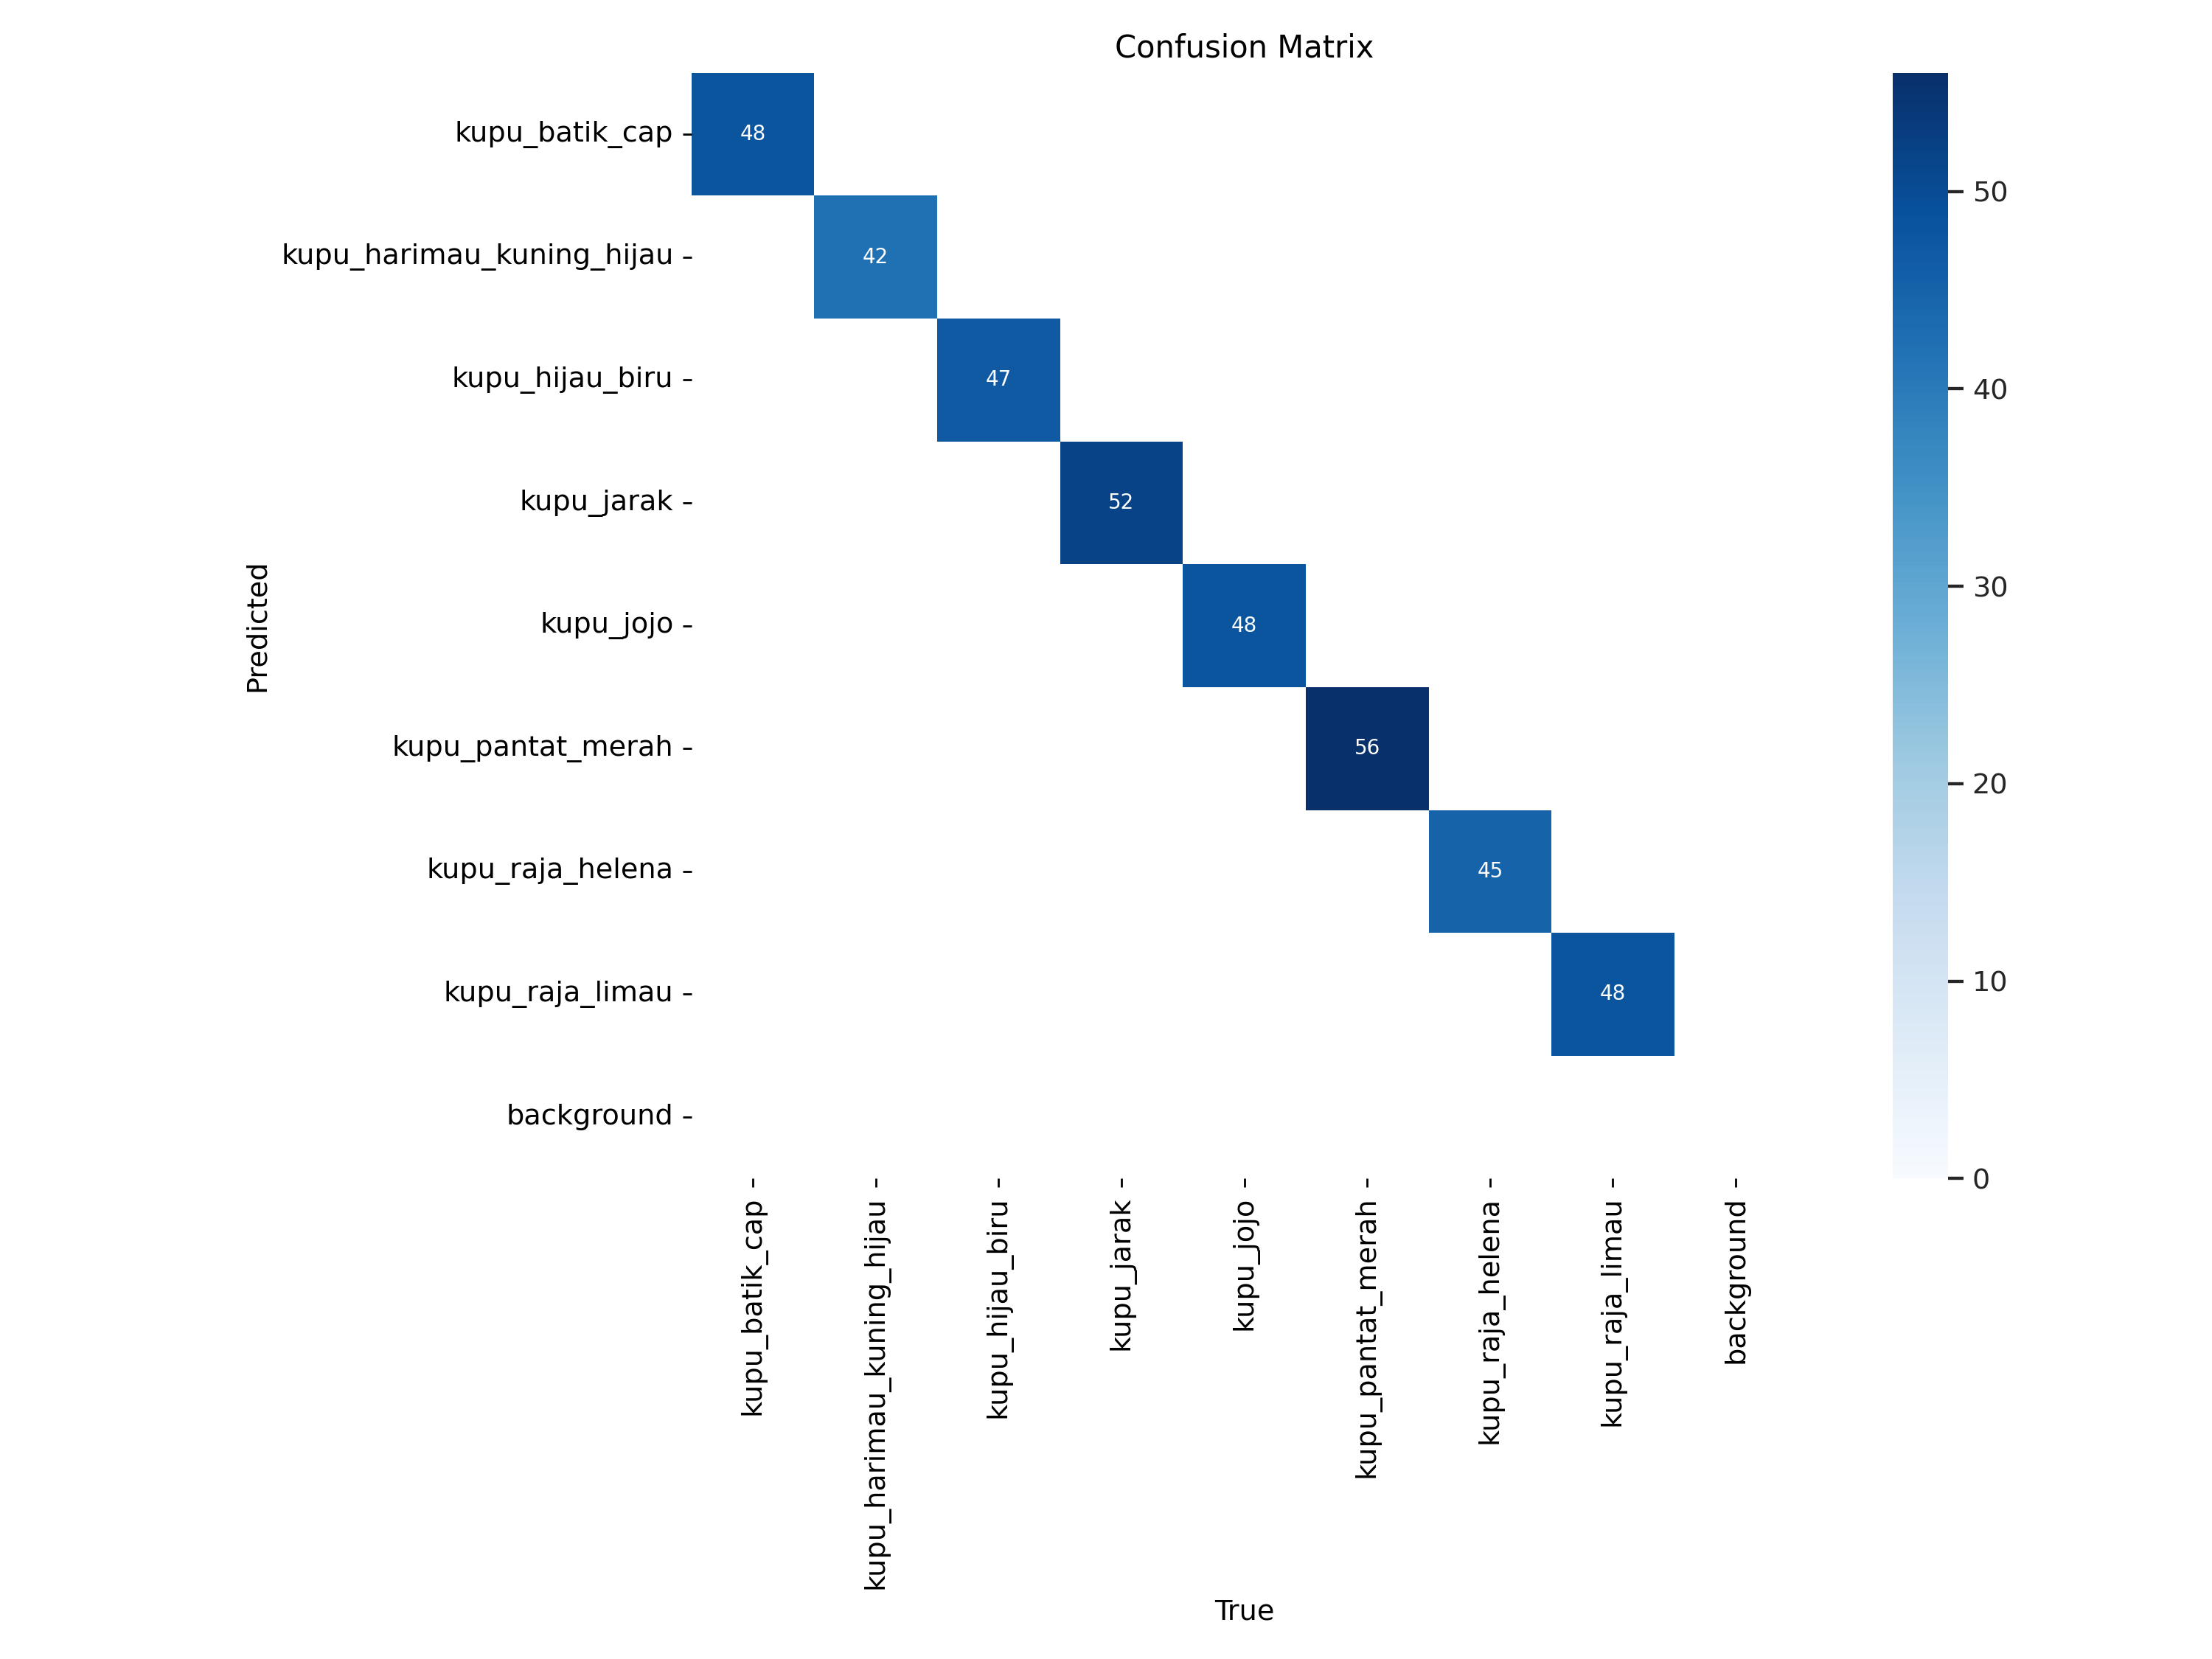

In [ ]:
Image(filename = '/content/runs/detect_yolov82/confusion_matrix.png')

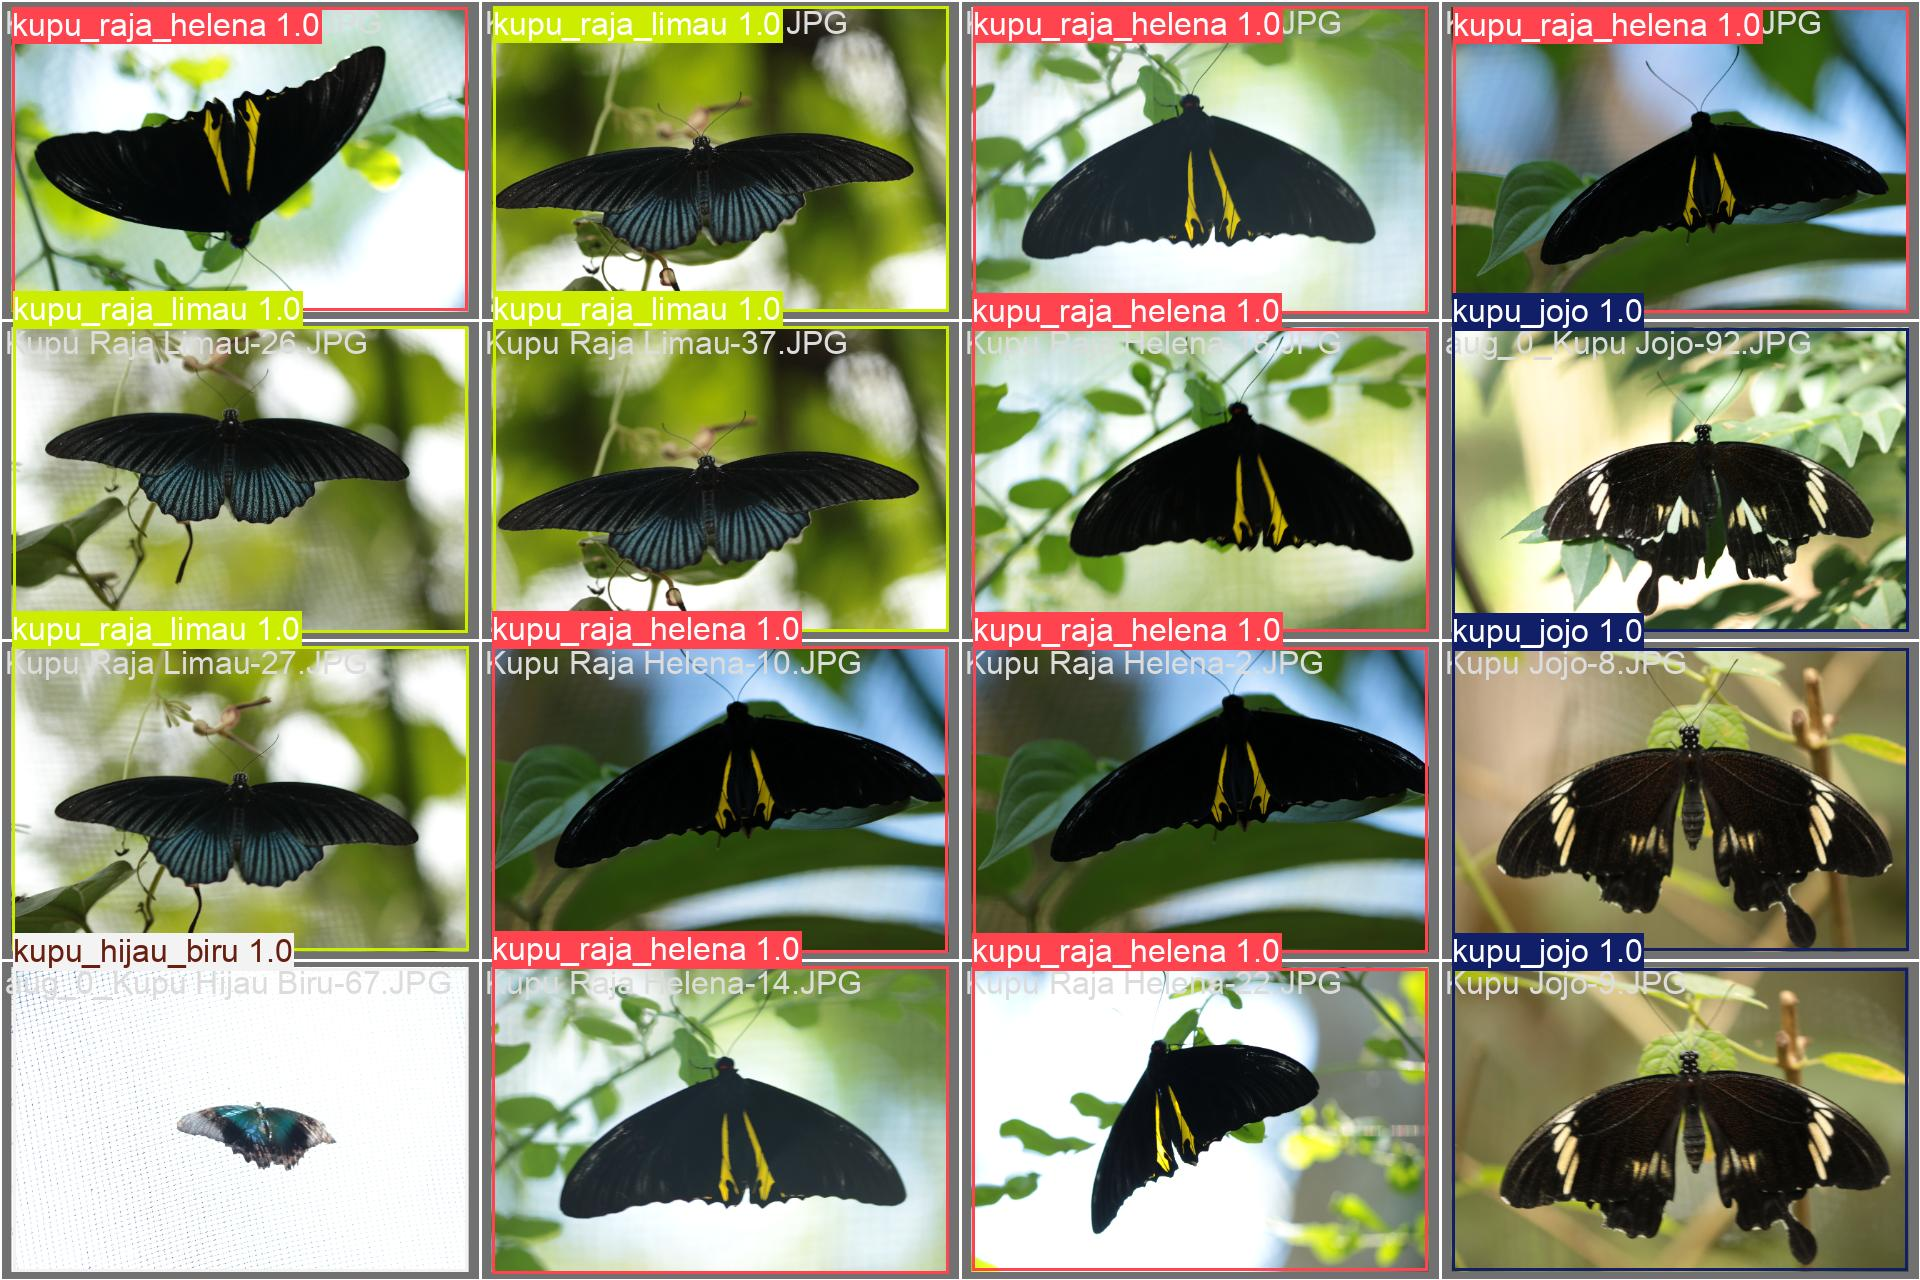

In [ ]:
Image(filename = '/content/runs/detect_yolov82/val_batch1_pred.jpg')

In [ ]:
import shutil
from google.colab import files

# Path dari folder yang ingin di-zip
folder_path = '/content/runs'

# Buat file zip dari folder tersebut di lokasi terpisah
shutil.make_archive('/content/runs_backup', 'zip', folder_path)

# Download file zip yang sudah dibuat
files.download('/content/runs_backup.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>